In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('test.csv')

Using TensorFlow backend.


## Setting up the image augmentation from last Lesson: 

In [3]:
IMG_SIZE = (224, 224)

train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

# validation data should not be augmented
val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 6) ## We've only been provided with 6 validation images

Found 20 validated image filenames belonging to 2 classes.
Found 6 validated image filenames belonging to 2 classes.


In [4]:
## Pull a single large batch of random validation data for testing after each epoch
testX, testY = val_gen.next()

### Load VGG16 (pre-trained ImageNet weights)

In [5]:
model = VGG16(include_top=True, weights='imagenet')

553467904/553467096 [==============================] - 22s 0us/step


In [8]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

## choose layers of VGG16 
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

new_model = Sequential()

# Add convolutional part 
new_model.add(vgg_model)

# Flatten the output of the VGG16 
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting 
new_model.add(Dropout(0.5))

# Add a dense layer
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer 
new_model.add(Dropout(0.5))

# Add a dense layer
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer 
new_model.add(Dropout(0.5))

# Add a dense layer
new_model.add(Dense(256, activation='relu'))

# Add a dense layer; Change the activation function to sigmoid so output of the last layer is in [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [9]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [10]:
## Set up optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [11]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
## Run for 10 epochs 
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

Epoch 1/10
3/3 [==============================] - 8s 3s/step - loss: 1.6476 - binary_accuracy: 0.4500 - val_loss: 0.6704 - val_binary_accuracy: 0.6667
Epoch 2/10
3/3 [==============================] - 1s 178ms/step - loss: 0.8825 - binary_accuracy: 0.5500 - val_loss: 0.7896 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 1s 208ms/step - loss: 0.5638 - binary_accuracy: 0.7500 - val_loss: 0.8268 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 0s 164ms/step - loss: 0.7164 - binary_accuracy: 0.4500 - val_loss: 0.8982 - val_binary_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 0s 166ms/step - loss: 0.9227 - binary_accuracy: 0.4500 - val_loss: 0.9384 - val_binary_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 0s 164ms/step - loss: 0.6844 - binary_accuracy: 0.6000 - val_loss: 0.8651 - val_binary_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 0s 166ms/step - loss: 0.8265 

In [13]:
# Plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of epochs
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

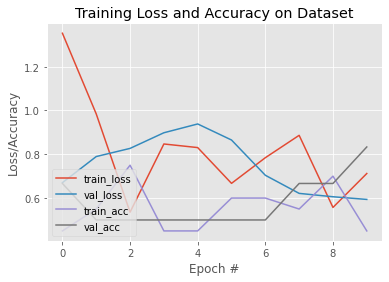

In [14]:
plot_history(history)

Decline in val_loss from epochs 0-7 shows the model stopped learning after 7 epochs

### Model: less dropout, same learning rate

In [16]:
new_model = Sequential()

new_model.add(vgg_model)

new_model.add(Flatten())

new_model.add(Dense(1024, activation='relu'))

new_model.add(Dropout(0.3))

new_model.add(Dense(512, activation='relu'))

new_model.add(Dropout(0.3))

new_model.add(Dense(256, activation='relu'))

new_model.add(Dense(1, activation='sigmoid'))

new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

Epoch 1/10
3/3 [==============================] - 1s 333ms/step - loss: 0.8095 - binary_accuracy: 0.4500 - val_loss: 0.7403 - val_binary_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 1s 170ms/step - loss: 0.8276 - binary_accuracy: 0.4000 - val_loss: 0.6572 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 1s 200ms/step - loss: 0.6147 - binary_accuracy: 0.7000 - val_loss: 0.7100 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 1s 188ms/step - loss: 0.6709 - binary_accuracy: 0.6000 - val_loss: 0.6196 - val_binary_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 1s 205ms/step - loss: 0.6254 - binary_accuracy: 0.7000 - val_loss: 0.6013 - val_binary_accuracy: 0.6667
Epoch 6/10
3/3 [==============================] - 1s 200ms/step - loss: 0.4720 - binary_accuracy: 0.7000 - val_loss: 0.5252 - val_binary_accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 1s 171ms/step - loss: 0.38

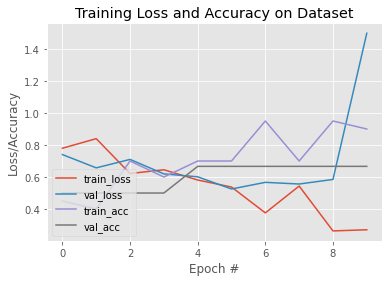

In [18]:
plot_history(history)

Train_loss dropped dramatically with the val_loss increased indicating a worse model

### Model: same amount of dropout, slower learning rate

In [21]:
new_model = Sequential()

new_model.add(vgg_model)

new_model.add(Flatten())

new_model.add(Dropout(0.5))

new_model.add(Dense(1024, activation='relu'))

new_model.add(Dropout(0.5))

new_model.add(Dense(512, activation='relu'))

new_model.add(Dropout(0.5))

new_model.add(Dense(256, activation='relu'))

new_model.add(Dense(1, activation='sigmoid'))

### Set up optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-6)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [22]:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

Epoch 1/10
3/3 [==============================] - 1s 343ms/step - loss: 0.7429 - binary_accuracy: 0.4500 - val_loss: 0.6836 - val_binary_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 0s 163ms/step - loss: 0.7833 - binary_accuracy: 0.3500 - val_loss: 0.6835 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 0s 167ms/step - loss: 1.0184 - binary_accuracy: 0.3000 - val_loss: 0.6832 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 1s 168ms/step - loss: 0.6331 - binary_accuracy: 0.6500 - val_loss: 0.6827 - val_binary_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 1s 196ms/step - loss: 0.8833 - binary_accuracy: 0.3000 - val_loss: 0.6820 - val_binary_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 1s 197ms/step - loss: 0.8019 - binary_accuracy: 0.5500 - val_loss: 0.6816 - val_binary_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 1s 167ms/step - loss: 0.56

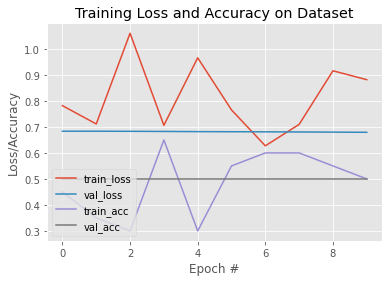

In [23]:
plot_history(history)

The performance is unstable with this architecture.  A flat val_loss curve. Between epoch 3 and 8 the train_loss goes down indicating overfit on the training data. 